In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import scipy.stats as stats
import datetime
import pingouin
import re
import statsmodels
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.formula.api import ols
from wordcloud import WordCloud, STOPWORDS
%matplotlib inline
sns.set_palette('Set3',12)

from surprise import Reader
from surprise import Dataset
from surprise import accuracy
from surprise import NormalPredictor, BaselineOnly, KNNBaseline, KNNBasic, KNNWithMeans, KNNWithZScore, SVD, NMF, CoClustering, SlopeOne
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV
from surprise.model_selection import cross_validate

# Table of contents
1. [INTRODUCTION](#1)
    <br>1.1 [Dataset](#1.1)
    <br>1.2 [Business significance](#1.2)
    <br>1.3 [Research questions](#1.3)
    <br>1.4 [Method](#1.4)
2. [EXPLORATORY DATA ANALYSIS](#2)
    <br>2.1 [Number of reviews, reviewers, products](#2.1)
    <br>2.2 [Breakdown of rating](#2.2)
    <br>2.3 [Word cloud of each rating](#2.3)
    <br>2.4 [Time series analysis](#2.4)
    <br>2.5 [Rating vs Helpfulness](#2.5)
3. [MODELLING](#3)
    <br>3.1 [Model selection](#3.1)
    <br>3.2 [Parameter tuning](#3.2)
    <br>3.3 [Evaluating prediction accuracy](#3.3)
    <br>3.4 [Applications](#3.4)
4. [CONCLUSIONS](#4)
5. [REFERENCES](#5)

**Disclaimer:** In this notebook, user and reviewer means the same thing. Similarly, item and product are also the same thing.

# 1. Introduction<a name="1"></a>
## 1.1 Datasets<a name="1.1"></a>

In [2]:
# Load the datasets
meta = pd.read_csv('metadata_category_clothing_shoes_and_jewelry_only.csv')
reviews = pd.read_csv('reviews_Clothing_Shoes_and_Jewelry_5.csv')

In [3]:
meta[:2]

,metadataid,asin,salesrank,imurl,categories,title,description,price,related,brand
0,2005401,B00004SR8Z,{'Clothing': 1631},http://ecx.images-amazon.com/images/I/41RfWLMD...,"[['Clothing, Shoes & Jewelry', 'Luggage & Trav...",Lewis N. Clark Deluxe Neck Stash,NaN,12.8,"{'also_bought': ['B004RJWFDU', 'B00920ZC3O', '...",Lewis N. Clark
1,2217897,B0000ZE74A,{'Clothing': 4742},http://ecx.images-amazon.com/images/I/41ryA-RO...,"[['Clothing, Shoes & Jewelry', 'Women', 'Cloth...",Vanity Fair Women's Lollipop Plus Size Cuff Le...,NaN,NaN,"{'also_bought': ['B004PEHJ6U', 'B0000TF5VK', '...",NaN


In [70]:
reviews[:2]

,Unnamed: 0,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,Time,year,month,helpful_vote,total,helpful_ratio
0,0,A1KLRMWW2FWPL4,0000031887,"Amazon Customer ""cameramom""","[0, 0]",This is a great tutu and at a really great pri...,5.0,Great tutu- not cheaply made,1297468800,"02 12, 2011",2011-02-12,2011,2,0,0,NaN
1,1,A2G5TCU2WDFZ65,0000031887,Amazon Customer,"[0, 0]",I bought this for my 4 yr old daughter for dan...,5.0,Very Cute!!,1358553600,"01 19, 2013",2013-01-19,2013,1,0,0,NaN


In [4]:
meta.shape

(23033, 10)

In [6]:
reviews.shape

(278677, 10)

In [7]:
print("Smallest number of reviews per user is ", min(reviews.groupby('reviewerID').asin.count()))
print("Smallest number of reviews per product is ", min(reviews.groupby('asin').reviewerID.count()))

Smallest number of reviews per user is  5
Smallest number of reviews per product is  5


These 2 datasets are taken from https://jmcauley.ucsd.edu/data/amazon/
<br>They are related to products in the Clothing, Shoes and Jewelry category on Amazon website. The 1st dataframe (meta) includes information of 23033 products and the 2nd (reviews) includes 278677 reviews of those products from 2003 to 2014.
Only products and users with at least 5 reviews are included.
<br><br> Several potential data science projects can be conducted on these 2 datasets. Some examples:
- Sentiment Analysis: classifying whether the review text is positive or negative
- Multiple Regression: predict helpfulness of reviews based on other variables (review length, rating, sentiment score, etc.)
- Recommender System: predict ratings for (user, product) pairs that are not yet available
- ...

In this project, I will build a recommender system based on the reviews dataset. 

## 1.2 Business Significance<a name="1.2"></a>
Some benefits of recommender system:
- Drive Traffic
- Deliver Relevant Content
- Engage Shoppers
- Convert Shoppers to Customers
- Increase Average Order Value
- Increase Number of Items per Order
- Control Merchandising and Inventory Rules
- Reduce Workload and Overhead
- Provide Reports
- Offer Advice and Direction

As a matter of fact, 35% of Amazon sales come from recommended items (McKinsey, 2013).

## 1.3 Research question<a name="1.3"></a>
The main research question is **_"How can we build a recommender system from the Amazon dataset of product reviews?"_**
<br><br>To answer the above question, some potential sub-questions need to be addressed:
- How many reviews, users, products are there?
- On average, how many reviews are there per user and per product?
- How does the rating distribution looks like?
- What words are the most popular in each rating?
- Do the number of reviews and rating distribution change over the years?
- Is there correlation between rating and helpfulness?
- What is the most suitable algorithm to build recommender system based on this dataset?
- What set of parameters give the best accuracy?
- What is the min, max, average prediction error?
- How can we implement the model into a recommender system (giving a list of top rated products for each user)?

## 1.4 Methods<a name="1.4"></a>
The project will include 2 main parts: Exploratory Data Analysis (EDA) and Modelling.
<br><br> For EDA, visual analysis and statistical analysis are the main methods. Graphs will be checked for trends and patterns. Time series is decomposed to look for trend and seasonality. One-way ANOVA and its non-parametric equivalent Kruskal-Wallis will be used to check for statistical significance of difference between different rating levels.
<br><br> For Modelling, a series of algorithms for collaborative filtering will be compared. Matrix Factorization method provided by "Surprise" library will be the main focus.

# 2. Exploratory Data Analysis (EDA)<a name="2"></a>
## 2.1 Number of reviews, reviewers, products<a name="2.1"></a>

In [8]:
n_reviews = len(reviews.index)
n_reviewers = len(set(reviews.reviewerID))
n_products = len(set(reviews.asin))

print("Total number of reviews: ", n_reviews)
print("Total number of reviewers: ", n_reviewers)
print("Total number of products: ", n_products)

print("On average, each reviewer gives :", round(n_reviews/n_reviewers,2), "reviews.")
print("On average, each product has :", round(n_reviews/n_products,2), "reviews.")

Total number of reviews:  278677
Total number of reviewers:  39387
Total number of products:  23033
On average, each reviewer gives : 7.08 reviews.
On average, each product has : 12.1 reviews.


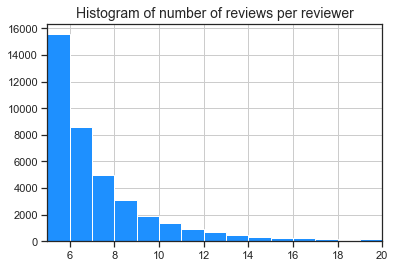

In [9]:
reviews.groupby('reviewerID').asin.count().hist(bins=15, range=(5,20),color='dodgerblue')
plt.xlim([5,20])
plt.title('Histogram of number of reviews per reviewer',size=14)
plt.show()

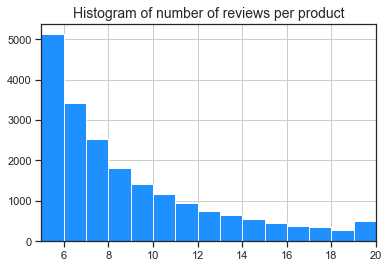

In [10]:
reviews.groupby('asin').reviewerID.count().hist(bins=15, range=(5,20), color='dodgerblue')
plt.title('Histogram of number of reviews per product',size=14)
plt.xlim([5,20])
plt.show()

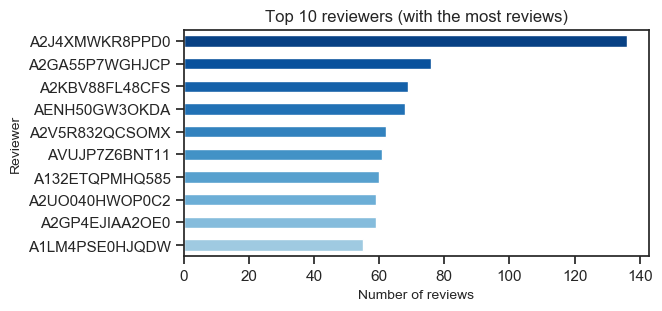

In [11]:
# Find top 10 reviewers
reviewer = reviews.groupby('reviewerID').asin.count()
top_reviewer = reviewer.sort_values(ascending=False)[:10]

# Plot the top 10 reviewers
plt.figure(figsize=(6,3), dpi=100)
reviewer_plt = top_reviewer.plot.barh(color=sns.color_palette('Blues_r',15))
reviewer_plt.invert_yaxis()
reviewer_plt.set_ylabel('Reviewer',size=10)
reviewer_plt.set_xlabel('Number of reviews',size=10)
reviewer_plt.set_title('Top 10 reviewers (with the most reviews)',size=12)
plt.show()

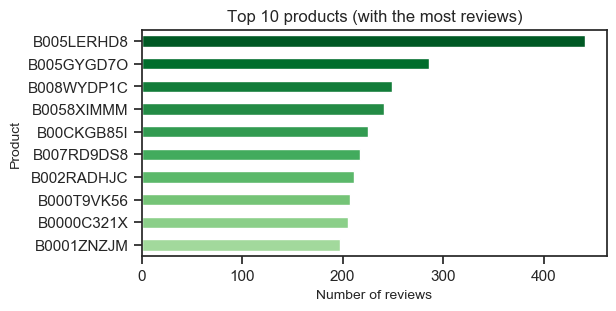

In [12]:
# Find top 10 products
product = reviews.groupby('asin').reviewerID.count()
top_product = product.sort_values(ascending=False)[:10]

# Plot the top 10 products
plt.figure(figsize=(6,3), dpi=100)
product_plt = top_product.plot.barh(color=sns.color_palette('Greens_r',15))
product_plt.invert_yaxis()
product_plt.set_ylabel('Product',size=10)
product_plt.set_xlabel('Number of reviews',size=10)
product_plt.set_title('Top 10 products (with the most reviews)',size=12)
plt.show()

## 2.2 Breakdown of rating<a name="2.2"></a>

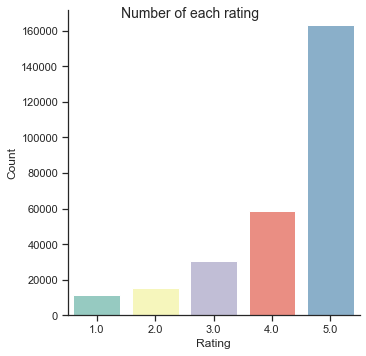

In [13]:
ax = sns.catplot("overall",data=reviews,kind='count')
ax.fig.suptitle('Number of each rating', fontsize=14)
ax.set_xlabels('Rating', fontsize=12) 
ax.set_ylabels('Count', fontsize=12)
plt.show()

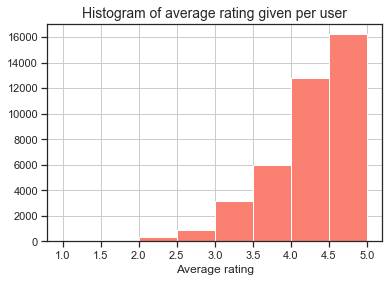

In [14]:
reviews.groupby('reviewerID').overall.mean().hist(bins=8, range=(1,5),color='salmon')
plt.title('Histogram of average rating given per user',size=14)
plt.xlabel('Average rating',size=12)
plt.show()

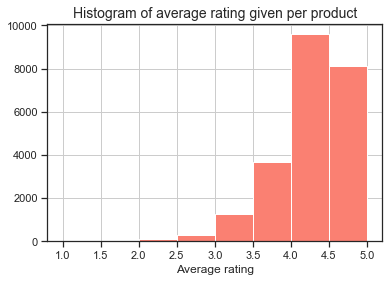

In [15]:
reviews.groupby('asin').overall.mean().hist(bins=8, range=(1,5),color='salmon')
plt.title('Histogram of average rating given per product',size=14)
plt.xlabel('Average rating',size=12)
plt.show()

## 2.3 Word cloud of each rating<a name="2.3"></a>
In this section, I will analyze the review summary to see which words are the most popular at each rating level.

In [16]:
regEx = re.compile('[^a-z]+')
def cleanReviews(reviewText):
    reviewText = reviewText.lower()
    reviewText = regEx.sub(' ', reviewText).strip()
    return reviewText

cluster = reviews.groupby("overall")["summary"].apply(list)
cluster = pd.DataFrame(cluster)
cluster.to_csv("cluster.csv")
cluster1 = pd.read_csv("cluster.csv")
cluster1["summaryClean"] = cluster1["summary"].apply(cleanReviews)

stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=100,
        max_font_size=50, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))
    
    fig = plt.figure(1, figsize=(8, 8))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

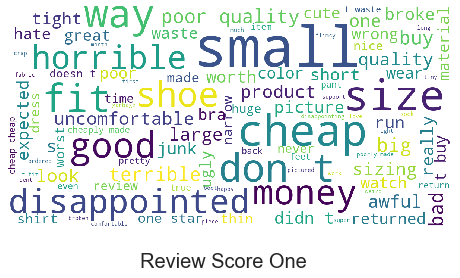

In [17]:
show_wordcloud(cluster1["summaryClean"][0], title = "Review Score One")

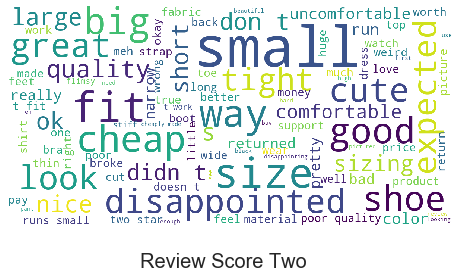

In [18]:
show_wordcloud(cluster1["summaryClean"][1] , title = "Review Score Two")

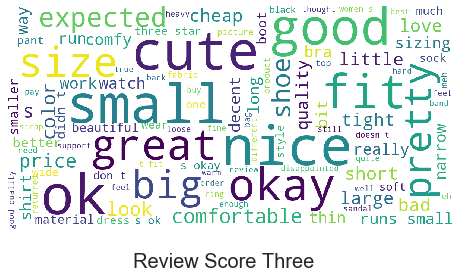

In [19]:
show_wordcloud(cluster1["summaryClean"][2], title = "Review Score Three")

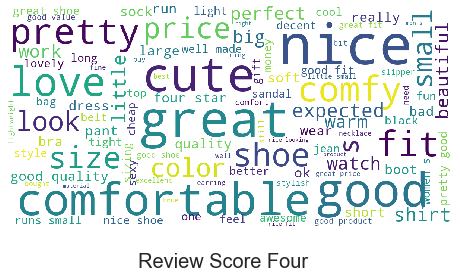

In [20]:
show_wordcloud(cluster1["summaryClean"][3], title = "Review Score Four")

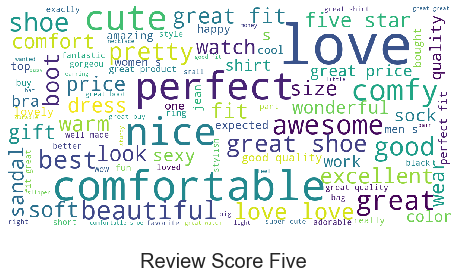

In [21]:
show_wordcloud(cluster1["summaryClean"][4], title = "Review Score Five")

**Rating 1** has mostly "negative" words such as _Disappointed, Horrible, Poor, etc._
<br> **Rating 3, 4 and 5** has mostly "positive" words such as _Comfortable, Perfect, Cute, Love, etc._
<br> **Rating 2** include a mix of negative and positive words.
<br>These results are foundations if one wants to conduct a **_Sentiment analysis._** (classifying review text as positive/negative)

## 2.4 Time series analysis<a name="2.4"></a>
### Number of rating over the years

In [22]:
# Extract year and month from unix review time column
df = reviews
df['Time'] = pd.to_datetime(df['unixReviewTime'],unit='s')
df['year'] = pd.DatetimeIndex(df['Time']).year
df['month'] = pd.DatetimeIndex(df['Time']).month

# Calculate number of reviews per month and save to a dataframe
dfTime = df.groupby(['year','month'])['overall'].count().to_frame()
dfTime = dfTime.reset_index()
dfTime['date'] = pd.to_datetime((dfTime.year*10000+dfTime.month*100+1).apply(str),format='%Y%m%d')
dfTime.head()

,year,month,overall,date
0,2003,3,1,2003-03-01
1,2003,12,1,2003-12-01
2,2004,7,1,2004-07-01
3,2004,9,3,2004-09-01
4,2004,12,2,2004-12-01


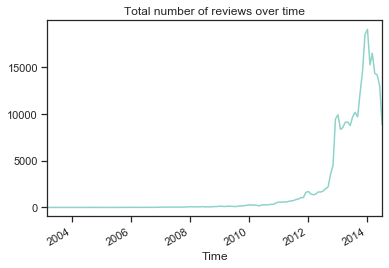

In [23]:
# Plot the number of reviews over time:
dfTime.plot(x='date',
           y='overall',
           title='Total number of reviews over time', legend=False)
plt.xlabel('Time',size = 12)
plt.show()

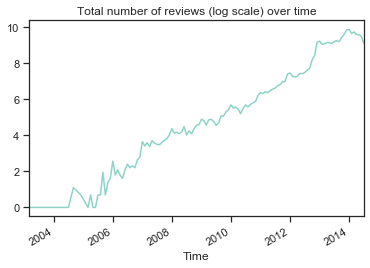

In [24]:
# Plot the number of reviews (log scale) over time:
dfTime['log_overall'] = dfTime.overall.apply(lambda x: np.log(x))
dfTime.plot(x='date',
           y='log_overall',
           title='Total number of reviews (log scale) over time', legend=False)
plt.xlabel('Time',size = 12)
plt.show()

The log scale is approximately a straight line, suggesting this is an exponential growth.

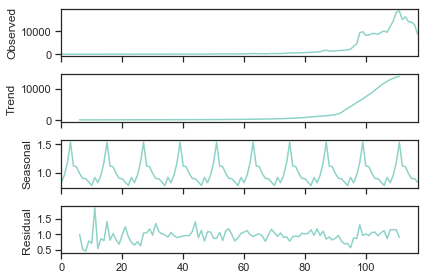

In [25]:
# Decompose the time series
result = seasonal_decompose(dfTime['overall'],
                           model='multiplicative', freq=12)
result.plot()
plt.show()

Residuals are close to 1, suggesting the chosen multiplicative model has a good fit on the time series data. Another point to note is that the trend is much larger in magnitude than the seasonal ccomponent (looking at the y axis).

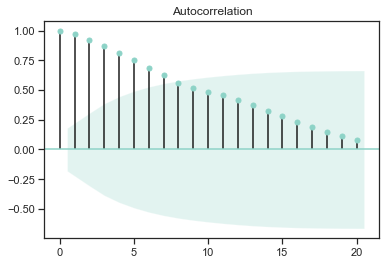

In [26]:
# Plot ACF and PACF to confirm there is a strong trend but weak seasonality
plot_acf(dfTime['overall'],lags=20)
plt.show()

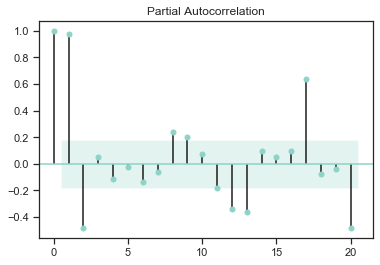

In [27]:
plot_pacf(dfTime['overall'],lags=20)
plt.show()

Correlation is above 95% confidence interval, showing that there is significant trend.

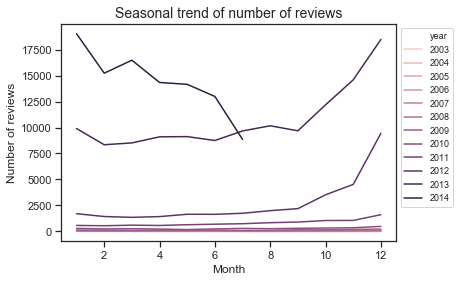

In [28]:
# Plot a seasonal graph
ax=sns.lineplot(data=dfTime,
            x='month',
            y='overall',
            hue='year',
            legend='full')

ax.set_xlabel('Month',size=12)
ax.set_ylabel('Number of reviews',size=12)
ax.set_title('Seasonal trend of number of reviews',size=14)
plt.legend(bbox_to_anchor=(1, 1),fontsize=9)
plt.show()

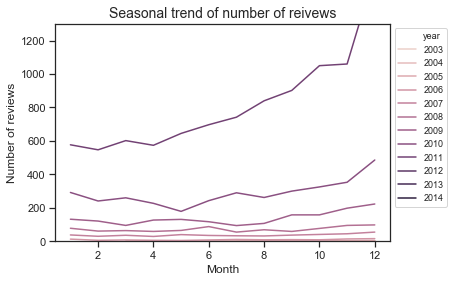

In [29]:
# Zoom in to 2003-2011
ax=sns.lineplot(data=dfTime,
            x='month',
            y='overall',
            hue='year',
            legend='full')

ax.set_xlabel('Month',size=12)
ax.set_ylabel('Number of reviews',size=12)
ax.set_title('Seasonal trend of number of reivews',size=14)
plt.legend(bbox_to_anchor=(1, 1),fontsize=9)
plt.ylim([0,1300])
plt.show()

There is a spike every December (possibly due to Christmas), but this seasonal spike is overshadowed by the exponential growth.

### Mean and Median rating over the years

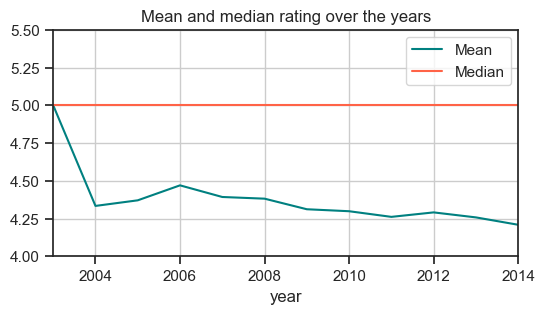

In [30]:
# Mean and median rating over the years
dfTime = df.groupby('year')['overall'].mean().to_frame()
dfTime = dfTime.reset_index()

mean_rate = df.groupby('year')['overall'].mean()
median_rate = df.groupby('year')['overall'].median()

plt.figure(figsize=(6,3),dpi=100)

ax1 = mean_rate.plot(color='teal', grid=True, label='Mean')
ax2 = median_rate.plot(color='tomato', grid=True, secondary_y=False, label='Median')

plt.title('Mean and median rating over the years')
plt.ylim([4,5.5])
plt.legend()
plt.show()

Median rating remained at 5 throughout the period while the mean rating gradually decreases from 5 to about 4.25 in 2014.

In [31]:
# To find out why mean rating decreases, I calculate the number of each rating level per year
data = pd.DataFrame(index=range(2003,2015))
data['Rating_1'] = reviews[reviews.overall==1].groupby('year').overall.count()
data['Rating_2'] = reviews[reviews.overall==2].groupby('year').overall.count()
data['Rating_3'] = reviews[reviews.overall==3].groupby('year').overall.count()
data['Rating_4'] = reviews[reviews.overall==4].groupby('year').overall.count()
data['Rating_5'] = reviews[reviews.overall==5].groupby('year').overall.count()
data

,Rating_1,Rating_2,Rating_3,Rating_4,Rating_5
2003,NaN,NaN,NaN,NaN,2
2004,NaN,1.0,NaN,1.0,4
2005,1.0,2.0,NaN,7.0,17
2006,5.0,3.0,5.0,22.0,80
2007,11.0,17.0,42.0,95.0,286
2008,28.0,39.0,65.0,178.0,558
2009,73.0,81.0,134.0,341.0,1032
2010,134.0,182.0,325.0,695.0,2122
2011,438.0,536.0,947.0,2024.0,5901
2012,1334.0,1694.0,3138.0,6476.0,20012


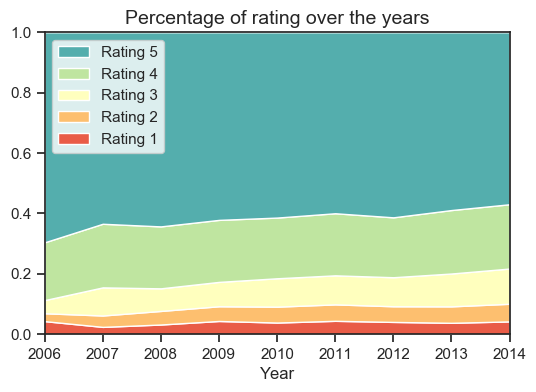

In [32]:
# We need to transform the data from raw data to percentage (fraction)
data_perc = data.divide(data.sum(axis=1), axis=0)
 
# Make the plot
fig = plt.figure(figsize=(6,4),dpi=100)
ax = fig.add_subplot(1, 1, 1)

plt.stackplot(range(2003,2015),  data_perc["Rating_1"],  data_perc["Rating_2"],  data_perc["Rating_3"],
              data_perc["Rating_4"], data_perc["Rating_5"],
              labels=['Rating 1','Rating 2','Rating 3','Rating 4','Rating 5'],
              colors=sns.color_palette("Spectral",5))

plt.legend(loc='upper left')
plt.margins(0,0)
plt.title('Percentage of rating over the years',size=14)
plt.xlabel('Year')
plt.xlim([2006,2014])
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='upper left')
plt.show()

The percentage of rating 3 increases significantly over 2006-2014 while the percentage of rating 5 decreases, leading to lower average rating.

## 2.5 Rating vs Helpfulness<a name="2.5"></a>

In [33]:
# Calculate helpfulness ratio
df = reviews
df['helpful'] = df.helpful.apply(lambda x: list(x[1:-1].split(',')))
df['helpful_vote'] = df.helpful.apply(lambda x: int(x[0]))
df['total'] = df.helpful.apply(lambda x: int(x[1]))
df['helpful_ratio'] = df.helpful_vote/df.total

In [34]:
# Check for abnormal helpful ratio (>1). Helpful ratio should be in the range [0,1] only.
df[df.helpful_ratio>1]

,Unnamed: 0,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,Time,year,month,helpful_vote,total,helpful_ratio
30730,30730,A353U0L2HAMSHV,B000JD2614,"Cricket ""Living life and loving it!""","[4, 2]",I have been waiting for these to go on sale fo...,5.0,A gift for me!,1234828800,"02 17, 2009",2009-02-17,2009,2,4,2,2.0


In [35]:
# Remove the row with helpful_ratio > 1 (probably due to typo)
df = df[df.helpful_ratio<=1]

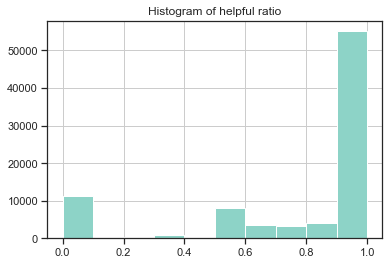

In [36]:
df['helpful_ratio'].hist()
plt.title('Histogram of helpful ratio')
plt.show()

In [37]:
# Keep only those with total votes >= 10 (for small number of votes, helpful_ratio is not reliable)
df_new = df[(df.total >= 10)]

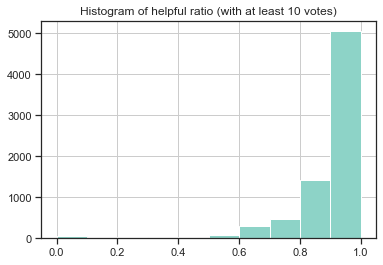

In [38]:
df_new.helpful_ratio.hist()
plt.title('Histogram of helpful ratio (with at least 10 votes)')
plt.show()

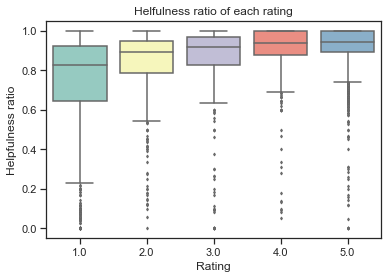

In [39]:
sns.boxplot(x="overall", y="helpful_ratio", data=df_new, flierprops = dict(markerfacecolor = '0.50', markersize = 2)).set(
    xlabel='Rating', 
    ylabel='Helpfulness ratio',
    title='Helfulness ratio of each rating'
)
plt.show()

### ANOVA of rating vs helpful_ratio (no transformation)

In [40]:
# ANOVA model:
model = ols('helpful_ratio ~ overall', data=df_new.sample(frac=0.1)).fit() # Take the sample (10%) because the test is not accurately at n>5000
aov_table = sm.stats.anova_lm(model, typ=2)
aov_table

,sum_sq,df,F,PR(>F)
overall,1.842036,1.0,95.26344,2.892893e-21
Residual,14.482837,749.0,NaN,NaN


ANOVA assumes that residuals follows normal distribution. I will check whether residuals are normally distributed

In [41]:
# Shapiro-Wilk test:
stats.shapiro(model.resid) # p<0.05 means non-normal

ShapiroResult(statistic=0.7765669822692871, pvalue=9.226268020903484e-31)

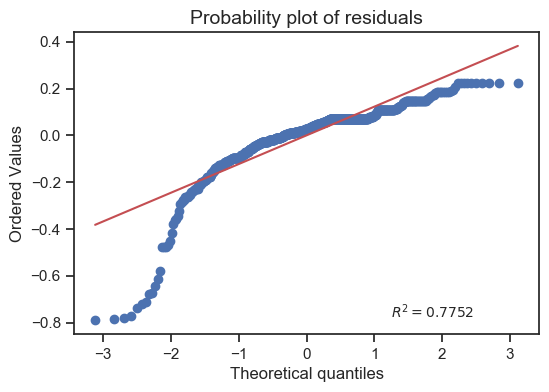

In [42]:
fig = plt.figure(figsize= (6, 4),dpi=100)
ax = fig.add_subplot(111)
normality_plot, stat = stats.probplot(model.resid, plot= plt, rvalue= True)
ax.set_title("Probability plot of residuals", fontsize= 14)
ax.set
plt.show()

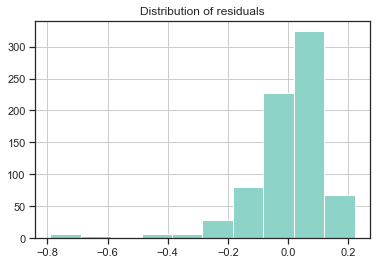

In [43]:
model.resid.hist()
plt.title("Distribution of residuals")
plt.show()

From Shapiro-Wilk test, Q-Q plot and histogram, the residuals are not normally distributed, violating the assumption of ANOVA. The result of ANOVA is thus not statistically reliable. Therefore, I will try to transform (Box-Cox) the helpful_ratio to see how residuals change and whether we can use ANOVA.

### ANOVA of rating vs helpful_ratio (after Box-Cox transformation)

Lambda value used for Transformation: 4.8949738757369


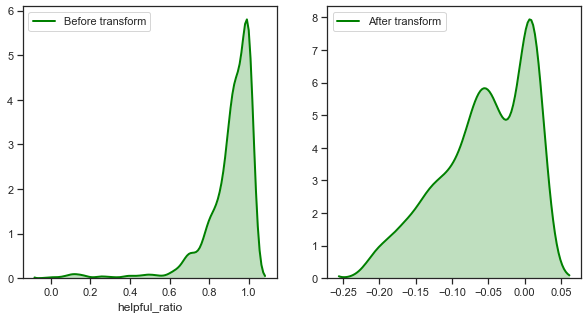

In [44]:
df_sample = df_new.sample(frac=0.1)
original_data = df_sample.helpful_ratio

# +0.01 in the formula to avoid the value of 0 because Box-cox transformation requires positive values only
fitted_data, fitted_lambda = stats.boxcox(original_data + 0.01) 

fig, ax = plt.subplots(1, 2) 
  
# plotting the original data and fitted data
sns.distplot(original_data, hist = False, kde = True, 
            kde_kws = {'shade': True, 'linewidth': 2},  
            label = "Before transform", color ="green", ax = ax[0]) 
  
sns.distplot(fitted_data, hist = False, kde = True, 
            kde_kws = {'shade': True, 'linewidth': 2},  
            label = "After transform", color ="green", ax = ax[1]) 
  
# adding legends to the subplots 
plt.legend(loc = "upper left") 
  
# rescaling the subplots 
fig.set_figheight(5) 
fig.set_figwidth(10) 

print(f"Lambda value used for Transformation: {fitted_lambda}")

In [45]:
df_sample['transformed_helpful_ratio'] = fitted_data

In [46]:
# ANOVA model:
model = ols('transformed_helpful_ratio ~ overall', data=df_sample).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
aov_table

,sum_sq,df,F,PR(>F)
overall,0.293411,1.0,89.065234,4.704354e-20
Residual,2.467457,749.0,NaN,NaN


In [47]:
# Shapiro-Wilk test:
stats.shapiro(model.resid) # p < 0.05 means non-normal

ShapiroResult(statistic=0.9539239406585693, pvalue=1.396505083610649e-14)

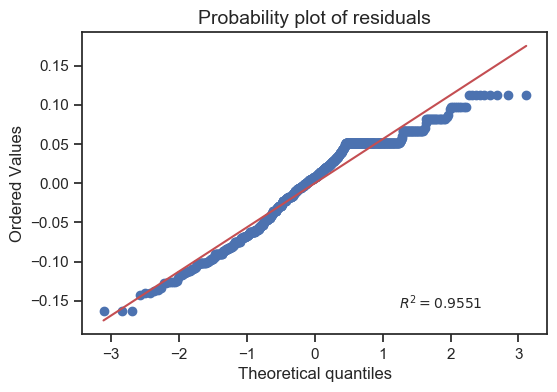

In [48]:
fig = plt.figure(figsize= (6, 4),dpi=100)
ax = fig.add_subplot(111)
normality_plot, stat = stats.probplot(model.resid, plot= plt, rvalue= True)
ax.set_title("Probability plot of residuals", fontsize= 14)
ax.set
plt.show()

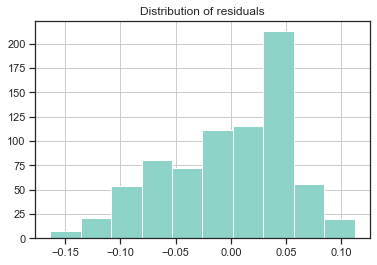

In [49]:
model.resid.hist()
plt.title("Distribution of residuals")
plt.show()

Residuals improve but are still not normally distributed, so we cannot use ANOVA even after Box-Cox transformation.
I will proceed to use the non-paramteric equivalent of ANOVA, which is Kruskal–Wallis test (analyzing median instead of mean).

In [50]:
# Kruskal–Wallis test 
stats.kruskal(df_sample.overall, df_sample.helpful_ratio) # p < 0.05 means there is correlation

KruskalResult(statistic=1107.045050993724, pvalue=9.720476686933686e-243)

Kruskal-Wallis test shows that the helpful_ratio is different among the ratings.

# 3. Modelling<a name="3"></a>
Recommender system is based on filtering. Among several types of filtering techniques, collaborative filtering has some major advantages:
- **No domain knowledge necessary:** We don't need domain knowledge because the embeddings are automatically learned.
- **Serendipity:** The model can help users discover new interests. 
- **Great starting point**: To some extent, the system needs only the feedback matrix to train a matrix factorization model. In particular, the system doesn't need contextual features. In practice, this can be used as one of multiple candidate generators.

Collaborative filtering is the suitable method for our dataset, and will be studied in the next section.

## 3.1 Model Selection<a name="3.1"></a>
<br>**"Surprise"** library provides several algorithms for collaborative filtering:
- **NormalPredictor**: Algorithm predicting a random rating based on the distribution of the training set, which is assumed to be normal.
- **BaselineOnly**: Algorithm predicting the baseline estimate for given user and item.
- **k-NN inspired algorithms**: A basic collaborative filtering algorithm relying on distance, including the following:
    - **KNNBasic**
    - **KNNWithMeans**: taking into account the mean ratings of each user.
    - **KNNWithZScore**: taking into account the z-score normalization of each user.
    - **KNNBaseline**: taking into account a baseline rating.
- **Matrix Factorization-based algorithms**:
    - **SVD**: When baselines are not used, this is equivalent to Probabilistic Matrix Factorization
    - **SVDpp**: The SVD++ algorithm, an extension of SVD taking into account implicit ratings.
    - **NMF**: A collaborative filtering algorithm based on Non-negative Matrix Factorization.
- **SlopeOne**
- **CoClustering**

<br> In this section, all the above algorithms (except for SVDpp because it takes up to 100 times longer than the other algorithms) will be tested on our dataset.
<br> <br>The original review dataset has nearly 280k rows, which is too large to test KNN algorithms on my laptop, so I will make 2 subsets to test the above algorithms.
<br> <br>"Surprise" library provides RMSE (Root Mean Square Error) and MAE (Mean Absolute Error) as measures of accuracy. RMSE gives higher penalty to large errors. MAE gives equal weights to all errors. The algorithms will be selected based on RMSE  through 3-fold cross validation. The lower the RMSE, the better the algorithms.

In [51]:
# Train-Test split (80% - 20%)
msk = np.random.rand(len(reviews)) <= 0.8
train = reviews[msk]
test = reviews[~msk]

In [52]:
# Surprise library:
# Step 1: Set the rating scale
reader = Reader(rating_scale=(1, 5))

# Step 2: Load the dataframe into a Dataset object:
# A sample (10%) from the trainset will be used to compare the algorithms (since KNN cannot work on such a large dataset)
train_sample = train.sample(frac=0.1)
data = Dataset.load_from_df(train_sample[['reviewerID', 'asin', 'overall']], reader)

# Step 3: Run the algorithms and save RMSE results to a dataframe:
benchmark = []
# Iterate over all algorithms
for algorithm in [NormalPredictor(), BaselineOnly(), SVD(), CoClustering(), NMF(), SlopeOne(),
                 KNNBasic(), KNNBaseline(), KNNWithMeans(), KNNWithZScore()]:
    # Perform 3-fold cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')    

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing t

,test_rmse,fit_time,test_time
Algorithm,,,
BaselineOnly,1.109277,0.330109,0.365022
KNNBaseline,1.110058,8.282508,0.217752
SVD,1.110654,2.874313,0.134972
KNNBasic,1.117075,5.692117,0.175861
KNNWithMeans,1.175545,9.594678,0.139958
KNNWithZScore,1.175667,7.217430,0.097072
SlopeOne,1.181703,3.343380,0.088462
CoClustering,1.199886,5.950745,0.098401
NMF,1.234313,4.989325,0.085449


It is clear that KNNBaseline, Baseline and SVD algorithms outperform the others. Their RMSE are the smallest.
<br><br>Because KNN cannot run on the original dataset (too large), I will focus on SVD. Some combinations of parameters will be checked to see if there is improvement on RMSE for SVD.

## 3.2 Parameter tuning<a name="3.2"></a>

#### Find the best combination of parameters for SVD

In [53]:
# I use the spare dataset (to save computational time) to find the best combinations of parameters

# Select your best algo with grid search.
param_grid = {'n_factors': [50,100,150],'n_epochs': [20,30], 'lr_all': [0.005,0.01],'reg_all':[0.02,0.1]}

gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3)

gs.fit(data)

# best RMSE score
print('Best RMSE ', gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print('Parameters that give best RMSE', gs.best_params['rmse'])

Best RMSE  1.109008161733202
Parameters that give best RMSE {'n_factors': 50, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.02}


The RMSE has improved very slightly.

## 3.3 Evaluating prediction accuracy<a name="3.3"></a>

#### Use the best parameters to train and test the original dataset

In [54]:
# I use the best parameters (found in step 3.2) to train and test the original dataset
train_data = Dataset.load_from_df(train[['reviewerID', 'asin', 'overall']], reader)
test_data = Dataset.load_from_df(test[['reviewerID', 'asin', 'overall']], reader)

algo = BaselineOnly()
algo.fit(train_data.build_full_trainset())

predictions = algo.test(test_data.build_full_trainset().build_testset())
accuracy.rmse(predictions)

Estimating biases using als...
RMSE: 1.0533


1.05331750784832

#### Create a dataframe of prediction errors for each (user, item) pair in the test set
Columns in the dataframe includes:
- uid: reviewer ID
- iid: product ID
- rui: actual rating in the testset
- est: predicted rating by our model
- details: False if no issue with prediction
- Iu: total number of ratings from that reviewer
- Ui: total number of ratings for that product
- err: error (|est - rui|)

In [57]:
trainset = train_data.build_full_trainset()
def get_Iu(uid):
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: # if user was not part of the trainset
        return 0

def get_Ui(iid):
    try:
       return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
       return 0

df_predictions = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
df_predictions['Iu'] = df_predictions.uid.apply(get_Iu) # number of items rated by that user
df_predictions['Ui'] = df_predictions.iid.apply(get_Ui) # number of users rating that item
df_predictions['err'] = abs(df_predictions.est - df_predictions.rui)
df_predictions[:3]

,uid,iid,rui,est,details,Iu,Ui,err
0,A1KLRMWW2FWPL4,0000031887,5.0,4.397331,{'was_impossible': False},5,15,0.602669
1,A1KLRMWW2FWPL4,B008NBSBHW,5.0,4.176333,{'was_impossible': False},5,3,0.823667
2,A16GFPNVF4Y816,0000031887,5.0,4.464093,{'was_impossible': False},3,15,0.535907


In [58]:
print("Mean prediction error is ", df_predictions['err'].mean())
print("Median prediction error is ", df_predictions['err'].median())

Mean prediction error is  0.823943049649329
Median prediction error is  0.6566383069773503


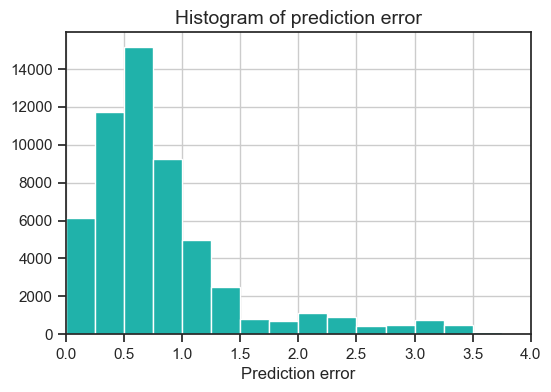

In [59]:
plt.figure(dpi=100)
df_predictions['err'].hist(bins=16, range=(0,4), color='lightseagreen')
plt.xlim([0,4])
plt.xlabel('Prediction error')
plt.title('Histogram of prediction error',size=14)
plt.show()

Overall, the model gives a good prediction on the testset. The mean and median errors are less than 1. From the histogram, the majority of the prediction errors are in the range (0,1).

#### Best 10 predictions (lowest errors):

In [60]:
best_predictions = df_predictions.sort_values(by='err')[:10]
best_predictions

,uid,iid,rui,est,details,Iu,Ui,err
6883,A2J4XMWKR8PPD0,B008J7ZUFG,5.0,5.0,{'was_impossible': False},112,5,0.0
29088,AQZSBXE2QA9C4,B002PHLVJA,5.0,5.0,{'was_impossible': False},18,130,0.0
6870,A2J4XMWKR8PPD0,B0018P3G3Y,5.0,5.0,{'was_impossible': False},112,63,0.0
6879,A2J4XMWKR8PPD0,B006W5VW3Q,5.0,5.0,{'was_impossible': False},112,3,0.0
6877,A2J4XMWKR8PPD0,B005GYGDFG,5.0,5.0,{'was_impossible': False},112,42,0.0
6885,A2J4XMWKR8PPD0,B009XM2Y64,5.0,5.0,{'was_impossible': False},112,26,0.0
35160,A34PW41XE2G31V,B003ZTXPJ6,5.0,5.0,{'was_impossible': False},16,14,0.0
6875,A2J4XMWKR8PPD0,B003UP68YE,5.0,5.0,{'was_impossible': False},112,8,0.0
6887,A2J4XMWKR8PPD0,B00ADCB51I,5.0,5.0,{'was_impossible': False},112,12,0.0
6872,A2J4XMWKR8PPD0,B002DUCU5I,5.0,5.0,{'was_impossible': False},112,14,0.0


#### Worst 10 predictions (highest errors):

In [61]:
worst_predictions = df_predictions.sort_values(by='err')[-10:]
worst_predictions

,uid,iid,rui,est,details,Iu,Ui,err
45240,A313XPHJ3L9OPW,B006OHTHY8,1.0,4.688317,{'was_impossible': False},5,42,3.688317
24673,A1QBCZ0R3JGUGE,B003B2XXLM,1.0,4.691010,{'was_impossible': False},10,32,3.691010
49823,A3369WHJN1WMV1,B00DRKKJ8S,1.0,4.691869,{'was_impossible': False},3,13,3.691869
1049,AV9BKZLWR2SMY,B000ARKLJS,1.0,4.702230,{'was_impossible': False},7,7,3.702230
53594,AXHU3RNRBPNVB,B00BN1K2N0,1.0,4.720832,{'was_impossible': False},6,10,3.720832
3992,A3M27ACKH1M1MZ,B0006AAS5Q,1.0,4.726027,{'was_impossible': False},3,30,3.726027
31971,A3NTEO3ZAO1ZJW,B003YUNCVC,1.0,4.750014,{'was_impossible': False},6,19,3.750014
894,AMW2I30QL5L93,B0000AT7N2,1.0,4.806373,{'was_impossible': False},13,56,3.806373
34771,AGPVLMET4R9GN,B006H1CJVE,1.0,4.814575,{'was_impossible': False},5,31,3.814575
26701,A211W8JLJFDIC0,B002HIJC8Y,1.0,4.832785,{'was_impossible': False},14,38,3.832785


#### Check a random bad prediction to find the reason

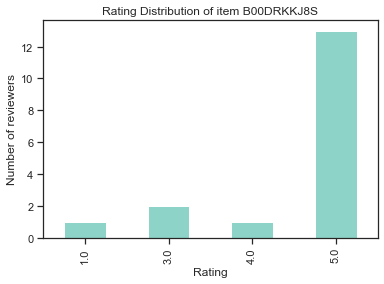

In [62]:
# Choose a random user and item in the 10 worst predictions:
random_user = worst_predictions.uid.sample().item()
random_item = worst_predictions[worst_predictions.uid == random_user].iid.item()

# Check rating distribution for the chosen item:
title = 'Rating Distribution of item ' + random_item

ax = reviews[reviews.asin == random_item].groupby('overall').size().plot(kind = "bar",
                                                                     title=title) 
ax.set_xlabel("Rating")
ax.set_ylabel("Number of reviewers")
plt.show()

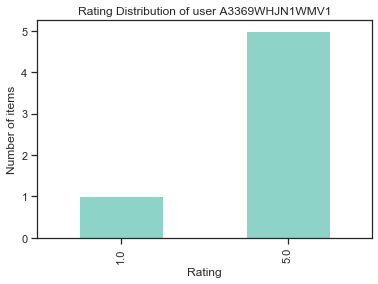

In [63]:
# Check rating distribution for the chosen user:
title = 'Rating Distribution of user ' + random_user

ax = reviews[reviews.reviewerID == random_user].groupby('overall').size().plot(kind = "bar",
                                                            title=title) 
ax.set_xlabel("Rating")
ax.set_ylabel("Number of items")
plt.show()

The bad prediction seems to be an outlier. The majority of users gave that item a high rating, which is similar to our prediction, but that particular user gave an usually low rating.

## 3.4 Applications<a name="3.4"></a>

### Predict the ratings for new combinations of (user, item)

In [64]:
# To predict new ratings (have not been rated before), I use the subset (1%) because the matrix created from
# the original dataset is too large.
reviews_new = reviews.sample(frac=0.01)
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(reviews_new[['reviewerID', 'asin', 'overall']], reader)

# First train an SVD algorithm on the movielens dataset.
trainset = data.build_full_trainset()
algo = gs.best_estimator['rmse']
algo.fit(trainset)

# Than predict ratings for all pairs (user, item) that are NOT in the training set.
testset = trainset.build_anti_testset()
predictions = algo.test(testset)

In [65]:
# Create a dictionary with keys being (user,item), and values being the corresponding predicted rating
users = reviews_new['reviewerID'].unique()
items = reviews_new['asin'].unique()

from collections import defaultdict
predicted_results = defaultdict(list)
for uid in users:
    for iid in items:
        est = algo.predict(uid, iid).est
        predicted_results[(uid,iid)].append(est)

In [66]:
# Pick a random userID and a random itemID to see the predicted rating:
random_user = reviews_new[['reviewerID']].sample().reviewerID.item()
random_item = reviews_new[['asin']].sample().asin.item()
print('Predicted rating of item ', random_item, 'by user ', random_user)
predicted_results[(random_user, random_item)]

Predicted rating of item  B00CBAFY1M by user  AWO7I8YIL4WM3


[4.320152647052191]

### Get top 10 recommendations for a user

In [67]:
# Create a function to retrieve top recommendations for a user (including only product that he/she has not rated)
def get_top_n(predictions, n=10):
    
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n


top_n = get_top_n(predictions, n=10)
tmp = pd.DataFrame.from_dict(top_n)
tmp_transpose = tmp.transpose()

In [68]:
def get_recommend(user_id):
    
    results = tmp_transpose.loc[user_id]
    df=pd.DataFrame()
    for x,y in results.items():
        df=df.append(meta[meta.asin==y[0]].iloc[0][['asin','title','price']])
    
    return df

In [69]:
# Pick a random user ID to check our function:
random_user = reviews_new[['reviewerID']].sample().reviewerID.item()
print('Top 10 recommendations for user ', random_user)
get_recommend(random_user)

Top 10 recommendations for user  A1LGYN6LO5YQVZ


,asin,price,title
5073,B001FWZ098,23.04,Platinum Plated Sterling Silver &quot;100 Face...
11120,B0050AFX2A,NaN,Fruit of the Loom Men's 7 pack boxer brief
7514,B002KMI7OC,NaN,Teva Women's Tirra Athletic Sandal
114,B0009F0Z38,NaN,Isotoner Women's Classic Satin Ballerina Slipper
10078,B004Y53ETQ,NaN,Skechers Women's Go Walk Ultimate Walking Shoe
8295,B004M6UD46,12.99,Men's Leather Wallet Euro Traveler Extra Capac...
954,B0006IEWWI,15.17,Casio STR300 60lap Sport Running Watch
15786,B008VPQOC4,12.99,Stacy Adams Men's Big Sleep Short
2192,B000G1JM02,NaN,Crocs Classic Clog (Infant/Toddler/Little Kid/...
4411,B002F9NH7W,24.21,Doctor Role Play Set


# 4.Conclusions <a name="4"></a>

##### EDA
1. The reviews dataset includes nearly 280k reviews from 39k reviewers for 23k products. Each reviewer/product has at least 5 reviews in the dataset. Maxixmum number of reviews per reviewer is nearly 140 and per product is over 400.
2. On average, each reviewer gives 7 reviews and each product has 12 reviews. Histograms of reviews are positively skewed (right-tail), meaning that majority of reviewers and products have a small number of reviews (about 5-20 reviews).
3. More than half (160k out of 280k) of reviews has a rating of 5. Less than 20k reviews have a rating of 1 or 2.
4. **Rating 1** reviews have mostly "negative" words such as _Disappointed, Horrible, Poor, etc._
<br> **Rating 3, 4 and 5** have mostly "positive" words such as _Comfortable, Perfect, Cute, Love, etc._
<br> **Rating 2** include a mix of negative and positive words.
5. The number of reviews grows exponentially over the years. There is little seasonal variation in the number of reviews.
<br> Mean rating decreases slightly over the period because the proportion of rating 5 goes down while that of rating 3 rises.
6. Higher rating seems to have a higher helpfulness ratio. Kruskal-Wallis test was used at the end instead of ANOVA because the residuals in ANOVA model do not meet the normality assumption.

##### Modelling
There are several filtering methods to provide users with a recommendation list. One of them is collaborative filtering, which has various advantages. We don't need knowledge about metadata of items or users. We only need a matrix of ratings. Based on matrix factorization, the matrix of ratings can be decomposed into a user matrix and a product matrix. Taking the dot product of those 2 matrices will give us prediction of new (user, product) pairs.
<br><br>Several collaborative filtering algorithms were tested on our dataset. SVD, a famous matrix factorization-based algorithm, gives a good prediction accuracy. The majority of prediction errors are less than 1.
<br><br>We can use the results to give the prediction to new (user, product) pairs and create a list of top 10 recommendations (highest predicted ratings).

# 5. References<a name="5"></a>
Amazon review data. (n.d.-a). Retrieved December 6, 2020, from https://jmcauley.ucsd.edu/data/amazon/
<br><br>How retailers can keep up with consumers | McKinsey. (2013). Retrieved December 6, 2020, from https://www.mckinsey.com/industries/retail/our-insights/how-retailers-can-keep-up-with-consumers#
<br><br>Kaur, M. (2020, December 4). Mandeep147/Amazon-Product-Recommender-System. https://github.com/mandeep147/Amazon-Product-Recommender-System (Original work published 2017)
<br><br>Liao, K. (2018a, November 19). Prototyping a Recommender System Step by Step Part 1: KNN Item-Based Collaborative Filtering. Medium. https://towardsdatascience.com/prototyping-a-recommender-system-step-by-step-part-1-knn-item-based-collaborative-filtering-637969614ea
<br><br>Liao, K. (2018b, November 19). Prototyping a Recommender System Step by Step Part 2: Alternating Least Square (ALS) Matrix…. Medium. https://towardsdatascience.com/prototyping-a-recommender-system-step-by-step-part-2-alternating-least-square-als-matrix-4a76c58714a1
<br><br>Welcome to Surprise’ documentation! —Surprise 1 documentation. (n.d.). Retrieved December 1, 2020, from https://surprise.readthedocs.io/en/stable/index.html
<br><br>William Vorhies on January 17, 2017 at 9:00am, & Blog, V. (n.d.). 5 Types of Recommenders. Retrieved December 6, 2020, from https://www.datasciencecentral.com/profiles/blogs/5-types-of-recommenders
